In [ ]:
import requests
from bs4 import BeautifulSoup
import sqlite3
import time
import re

# 1. データベースの準備
dbname = 'suumo.db'
conn = sqlite3.connect(dbname)
cur = conn.cursor()

cur.execute('DROP TABLE IF EXISTS properties')

cur.execute('''
    CREATE TABLE properties (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        name TEXT,
        station TEXT,
        price INTEGER,
        age INTEGER,
        floor_plan TEXT,
        floor_num TEXT
    )
''')
conn.commit()

# 2. スクレイピング設定
# 東京４区（千代田・中央・港・新宿）
base_url = "https://suumo.jp/jj/chintai/ichiran/FR301FC001/?ar=030&bs=040&ta=13&sc=13101&sc=13102&sc=13103&sc=13104&cb=0.0&ct=9999999&et=9999999&cn=9999999&mb=0&mt=9999999&shkr1=03&shkr2=03&shkr3=03&shkr4=03&fw2=&srch_navi=1"

def get_data():
    headers = {
        "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36"
    }

    for page in range(1, 4):
        print(f"--- Page {page} を取得中... ---")
        url = f"{base_url}&page={page}"
        
        try:
            res = requests.get(url, headers=headers, timeout=10)
            res.encoding = 'utf-8'
            
            soup = BeautifulSoup(res.text, 'html.parser')
            items = soup.find_all("div", class_="cassetteitem")

            if not items:
                print("物件情報が見つかりませんでした")
                break

            data_list = []
            
            for item in items:
                try:
                    # --- 建物情報の取得 ---
                    title_elem = item.find("div", class_="cassetteitem_content-title")
                    name = title_elem.text.strip() if title_elem else "不明"
                    
                    station_elem = item.find("div", class_="cassetteitem_detail-col1")
                    station = station_elem.text.strip() if station_elem else "不明"
                    
                    age_elem = item.find("li", class_="cassetteitem_detail-col3")
                    age = 99
                    if age_elem:
                        age_text = age_elem.find_all("div")[0].text.strip()
                        if "新築" in age_text:
                            age = 0
                        else:
                            age_match = re.search(r'\d+', age_text)
                            age = int(age_match.group()) if age_match else 99

                    # --- 部屋情報の取得 ---
                    tbody = item.find("table", class_="cassetteitem_other")
                    if tbody:
                        for tr in tbody.find("tbody").find_all("tr"):
                            try:
                                tds = tr.find_all("td")
                                if len(tds) < 6: 
                                    continue


                                # 1. 階数 (列番号 2)
                                floor_num = tds[2].text.strip()

                                # 2. 家賃 (列番号 3)
                                price_li = tds[3].find("li")
                                if price_li:
                                    price_text = price_li.text.strip()
                                    price = int(float(price_text.replace("万円", "")) * 10000)
                                else:
                                    continue

                                # 3. 間取り (列番号 5)
                                # "3SLDK81.68m2" のようになっているので分離する
                                raw_floor_plan = tds[5].text.strip()
                                
                                match = re.search(r'^(ワンルーム|\d[SLDKR]+)', raw_floor_plan)
                                if match:
                                    floor_plan = match.group(1)
                                else:
                                    floor_plan = raw_floor_plan # うまく取れなければそのまま保存

                                data_list.append((name, station, price, age, floor_plan, floor_num))
                            except Exception:
                                continue

                except Exception:
                    continue

            if data_list:
                cur.executemany("INSERT INTO properties (name, station, price, age, floor_plan, floor_num) VALUES (?, ?, ?, ?, ?, ?)", data_list)
                conn.commit()
                print(f" -> {len(data_list)} 件保存しました")
            
            time.sleep(3)
            
        except Exception as e:
            print(f"エラー発生（スキップします）: {e}")
            continue

if __name__ == "__main__":
    get_data()
    conn.close()
    print("完了！ データを取り直しました。")

--- Page 1 を取得中... ---
 -> 30 件保存しました
--- Page 2 を取得中... ---
 -> 30 件保存しました
--- Page 3 を取得中... ---
 -> 30 件保存しました
完了！ データを取り直しました。


/var/folders/pp/sbdc5m6s16g6j6c417vrcfd00000gn/T/ipykernel_80873/2780565234.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/pp/sbdc5m6s16g6j6c417vrcfd00000gn/T/ipykernel_80873/2780565234.py:86: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


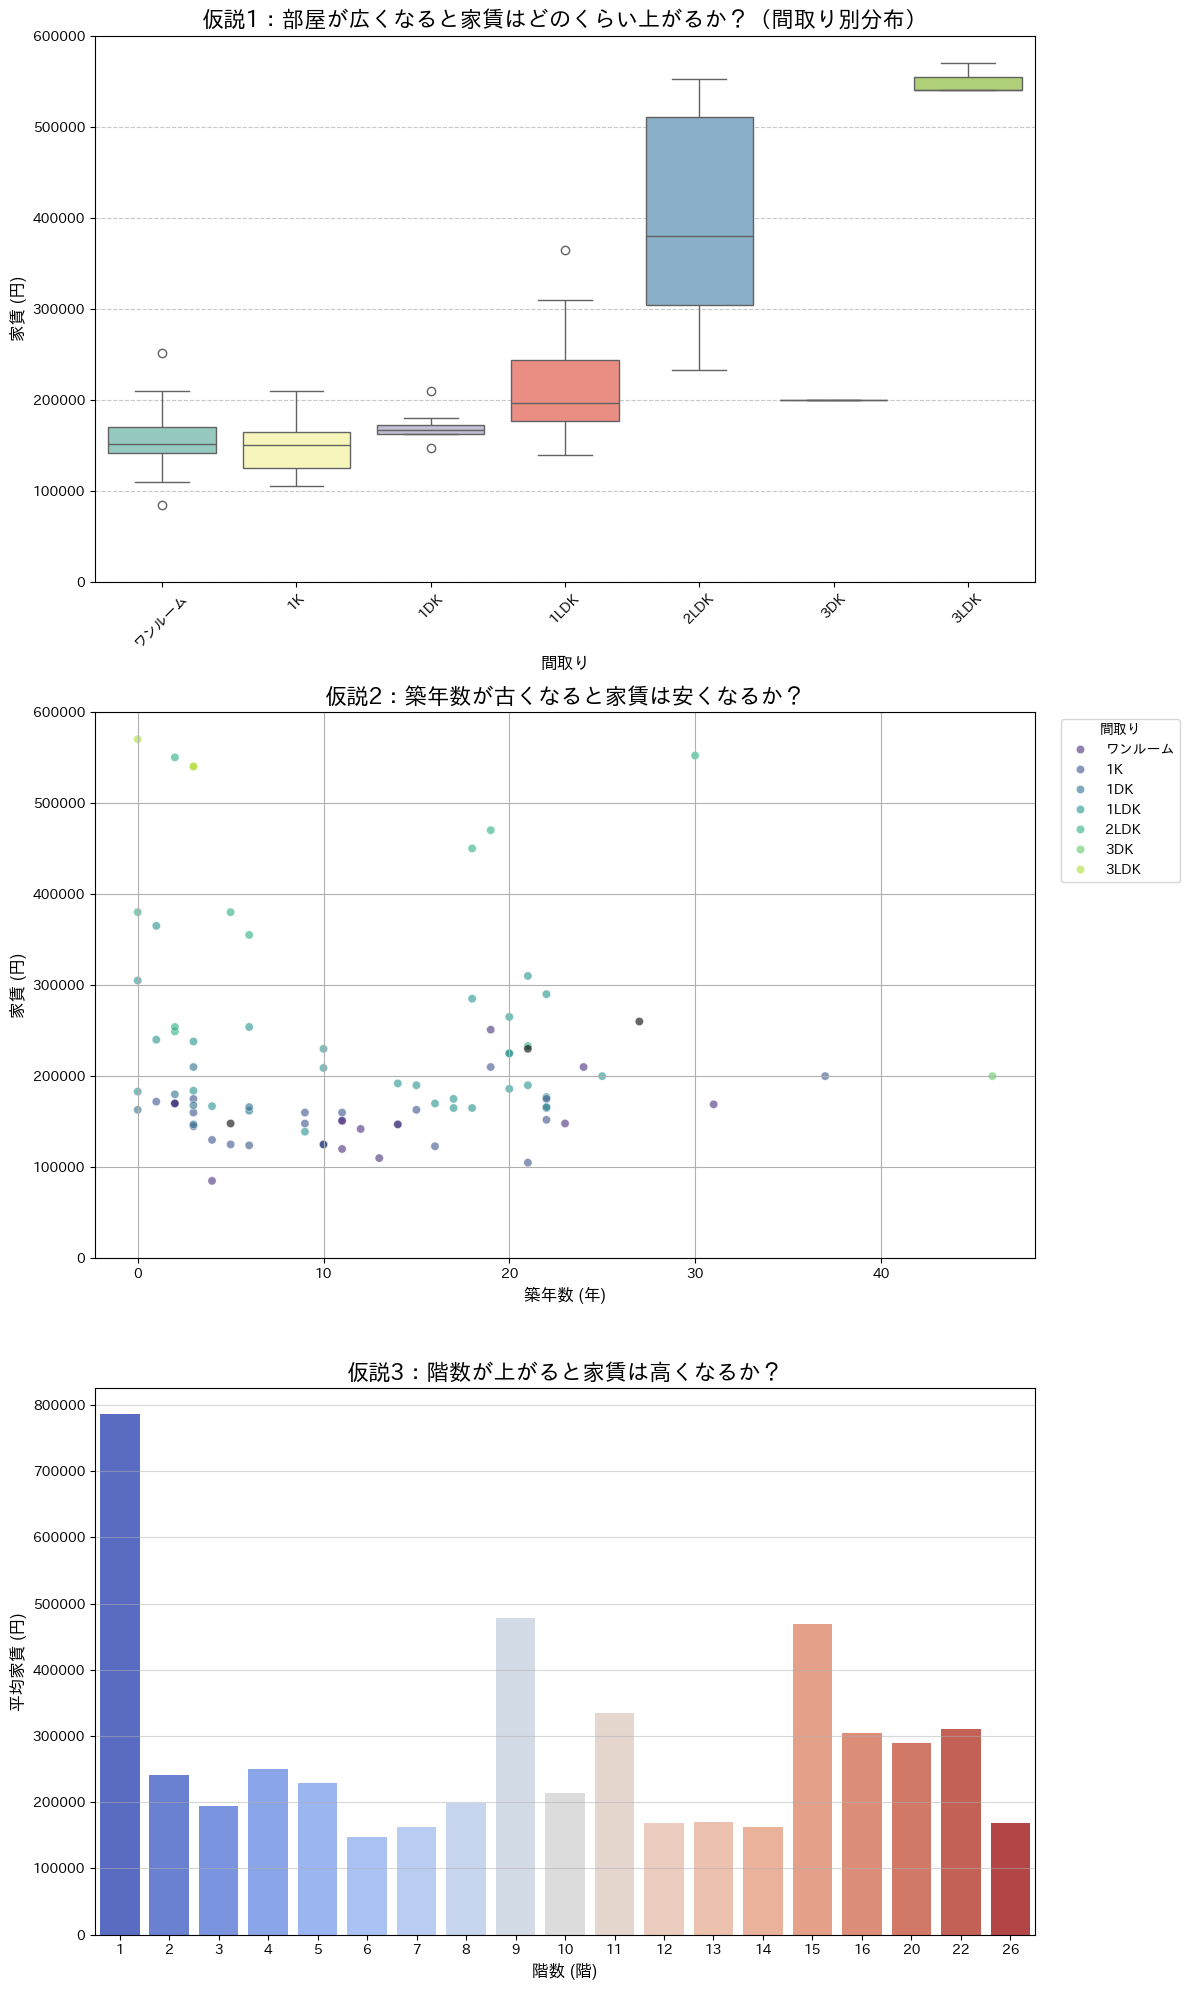

In [ ]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib
import re

# 1. データの準備
conn = sqlite3.connect('suumo.db')
df = pd.read_sql("SELECT * FROM properties", conn)
conn.close()

# --- データの前処理：階数の数値化 ---
def extract_floor(text):
    if not text: return None
    match = re.search(r'(\d+)', str(text))
    if match:
        return int(match.group(1))
    return None

df['floor_number'] = df['floor_num'].apply(extract_floor)

# --- データの前処理：間取りの並び順（狭い順） ---
custom_order = [
    'ワンルーム', '1K', '1DK', '1LDK', 
    '2K', '2DK', '2LDK', 
    '3K', '3DK', '3LDK', 
    '4K', '4DK', '4LDK'
]
# データに存在する間取りだけを抽出
existing_plans = [plan for plan in custom_order if plan in df['floor_plan'].unique()]

# 2. グラフの描画（3つの図を縦に並べる）
fig, axes = plt.subplots(3, 1, figsize=(12, 20)) 
# 【グラフ1】間取りごとの家賃分布（箱ひげ図）
sns.boxplot(
    data=df, 
    x='floor_plan', 
    y='price', 
    order=existing_plans, # 狭い順に指定
    palette='Set3',
    ax=axes[0]
)
axes[0].set_title('仮説1：部屋が広くなると家賃はどのくらい上がるか？（間取り別分布）', fontsize=16)
axes[0].set_xlabel('間取り', fontsize=12)
axes[0].set_ylabel('家賃 (円)', fontsize=12)
axes[0].set_ylim(0, 600000)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)


# 【グラフ2】築年数と家賃の関係（散布図）
sns.scatterplot(
    data=df, 
    x='age', 
    y='price', 
    hue='floor_plan', 
    hue_order=existing_plans,
    alpha=0.6, 
    palette='viridis',
    ax=axes[1]
)
axes[1].set_title('仮説2：築年数が古くなると家賃は安くなるか？', fontsize=16)
axes[1].set_xlabel('築年数 (年)', fontsize=12)
axes[1].set_ylabel('家賃 (円)', fontsize=12)
axes[1].set_ylim(0, 600000)
axes[1].grid(True)
axes[1].legend(title='間取り', bbox_to_anchor=(1.02, 1), loc='upper left')


# 【グラフ3】階数と平均家賃の関係（棒グラフ）
# 階数ごとの平均値を計算
floor_price = df.groupby('floor_number')['price'].mean().reset_index()

sns.barplot(
    data=floor_price,
    x='floor_number',
    y='price',
    palette='coolwarm',
    ax=axes[2]
)
axes[2].set_title('仮説3：階数が上がると家賃は高くなるか？', fontsize=16)
axes[2].set_xlabel('階数 (階)', fontsize=12)
axes[2].set_ylabel('平均家賃 (円)', fontsize=12)
axes[2].grid(axis='y', alpha=0.5)

# レイアウト調整
plt.tight_layout()
plt.show()

In [ ]:
%%writefile app.py
import flet as ft
import sqlite3

def main(page: ft.Page):
    # アプリの基本設定
    page.title = "SUUMO賃貸データ検索アプリ"
    page.theme_mode = ft.ThemeMode.LIGHT
    page.window_width = 1000
    page.window_height = 800
    page.padding = 20

    # 1. データベースからデータを取る関数
    def get_data_from_db(keyword=""):
        conn = sqlite3.connect('suumo.db')
        cur = conn.cursor()
        
        if keyword:
            query = """
                SELECT name, station, price, age, floor_plan 
                FROM properties 
                WHERE station LIKE ? OR name LIKE ?
            """
            cur.execute(query, (f'%{keyword}%', f'%{keyword}%'))
        else:
            cur.execute("SELECT name, station, price, age, floor_plan FROM properties LIMIT 100")
            
        rows = cur.fetchall()
        conn.close()
        return rows

    # 2. データを画面の「表」に変換する関数
    def create_table_rows(data):
        rows = []
        for row in data:
            rows.append(
                ft.DataRow(
                    cells=[
                        ft.DataCell(ft.Text(row[0], size=12, weight="bold")), # 物件名
                        ft.DataCell(ft.Text(row[1], size=12)),                # 駅
                        ft.DataCell(ft.Text(f"{row[2]:,}円", color="blue")),  # 家賃
                        ft.DataCell(ft.Text(f"築{row[3]}年")),                # 築年数
                        ft.DataCell(ft.Text(row[4])),                         # 間取り
                    ]
                )
            )
        return rows

    # 3. 画面パーツの作成
    title_text = ft.Text("賃貸データ分析ダッシュボード", size=24, weight="bold", color="teal")
    status_text = ft.Text("データを読み込み中...", color="grey")

    data_table = ft.DataTable(
        columns=[
            ft.DataColumn(ft.Text("物件名")),
            ft.DataColumn(ft.Text("最寄駅")),
            ft.DataColumn(ft.Text("家賃", numeric=True)),
            ft.DataColumn(ft.Text("築年数", numeric=True)),
            ft.DataColumn(ft.Text("間取り")),
        ],
        rows=[],
        border=ft.border.all(1, "grey"),
        vertical_lines=ft.border.BorderSide(1, "grey"),
        heading_row_color=ft.colors.BLUE_GREY_50,
        expand=True
    )

    # 4. イベント処理
    def search_click(e):
        keyword = search_field.value
        results = get_data_from_db(keyword)
        data_table.rows = create_table_rows(results)
        
        if len(results) == 0:
            status_text.value = "データが見つかりませんでした。"
            status_text.color = "red"
        else:
            status_text.value = f"検索結果: {len(results)} 件"
            status_text.color = "black"
            
        page.update()

    search_field = ft.TextField(
        label="駅名や物件名で検索（例: 新宿）", 
        width=400, 
        prefix_icon=ft.icons.SEARCH,
        on_submit=search_click
    )
    search_button = ft.ElevatedButton(text="検索", on_click=search_click)

    initial_data = get_data_from_db()
    data_table.rows = create_table_rows(initial_data)
    status_text.value = f"全データ表示中（最新100件）"

    page.add(
        ft.Column([
            title_text,
            ft.Divider(),
            ft.Row([search_field, search_button], alignment="center"),
            status_text,
            ft.Container(
                content=ft.Column([data_table], scroll=ft.ScrollMode.AUTO),
                height=500,
                border=ft.border.all(1, "grey50"),
                border_radius=10,
                padding=10
            )
        ])
    )

if __name__ == "__main__":
    ft.app(target=main)

Writing app.py
